In [1]:
import os
from tqdm import tqdm
import numpy as np

import torch
import torchvision

from PIL import Image
import matplotlib

In [2]:
class type1(torch.nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.conv2d_1 = torch.nn.Sequential(
                        torch.nn.Conv2d(inp, inp, kernel_size=3, stride=1, padding=1),
                        torch.nn.BatchNorm2d(inp))
        self.conv2d_2 = torch.nn.Sequential(
                        torch.nn.Conv2d(out, out, kernel_size=3, stride=1, padding=1),
                        torch.nn.BatchNorm2d(out))
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        out = self.conv2d_1(x)
        out = self.conv2d_2(out)
        out = self.relu(out)
        return out

In [4]:
class type2(torch.nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.conv2d_1 = torch.nn.Sequential(
                        torch.nn.Conv2d(inp, inp, kernel_size=3, stride=1, padding=1),
                        torch.nn.BatchNorm2d(inp))
        self.conv2d_2 = torch.nn.Sequential(
                            torch.nn.Upsample(scale_factor=2),
                            torch.nn.Conv2d(inp, out, kernel_size=3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(out))
        self.upsample = torch.nn.Sequential(
                            torch.nn.Upsample(scale_factor=2),
                            torch.nn.Conv2d(inp, out, kernel_size=3, stride=1, padding=1))
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        out = self.conv2d_1(x)
        out = self.conv2d_2(out)
        out += self.upsample(x)
        out = self.relu(out)
        return out

In [5]:
resnet = torchvision.models.resnet18(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


In [6]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Мы берем 

  * (conv1)
  * (bn1)
  * (relu)
  * (maxpool)
  * (layer1)
  * (layer2)
  * (layer3)
  * (layer4)

In [7]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18(weights="DEFAULT")

        self.conv1 = torch.nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.nn.functional.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        return out

In [8]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.up = torch.nn.Upsample(scale_factor=2)
        
        
        self.layer1 = torch.nn.Sequential(*[type2(512, 256),
                            type1(256, 256)])

        self.layer2 = torch.nn.Sequential(*[type2(256, 128),
                            type1(128, 128)])

        self.layer3 = torch.nn.Sequential(*[type2(128, 64),
                            type1(64, 64)])

        self.layer4 = torch.nn.Sequential(*[type1(64, 64),
                            type1(64, 64)])
        
        self.resize = torch.nn.Sequential(
                            torch.nn.Upsample(scale_factor=4),
                            torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1))
        

    
    
    def forward(self, x):
        out = x.view(-1, 512, 8, 8)
        out = self.up(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.resize(out)
        return out

In [9]:
class Autoencoder(torch.nn.Module):
    def __init__(self, quantification):
        super().__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        self.quantification = quantification
    
    def forward(self, x):
        out = self.enc(x)
        out = torch.clamp(out, 0.0, 1.0)
        out = out + (1 / 2 ** self.quantification) * (torch.rand_like(out) * 0.5 - 0.5)
        out = self.dec(out)
        return torch.nn.functional.sigmoid(out)

In [10]:
transform = torchvision.transforms.Compose(
        [
         torchvision.transforms.ToTensor()
        ])

uni_image = torchvision.datasets.ImageFolder('/kaggle/input/130k-images-512x512-universal-image-embeddings', 
        
        transform=transform
                                                )
train_loader =  torch.utils.data.DataLoader(uni_image, batch_size=32, shuffle=True, num_workers=8)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 5/4142 [00:12<1:36:33,  1.40s/it] 

____________________________
Epoch: 0 | iter: 5


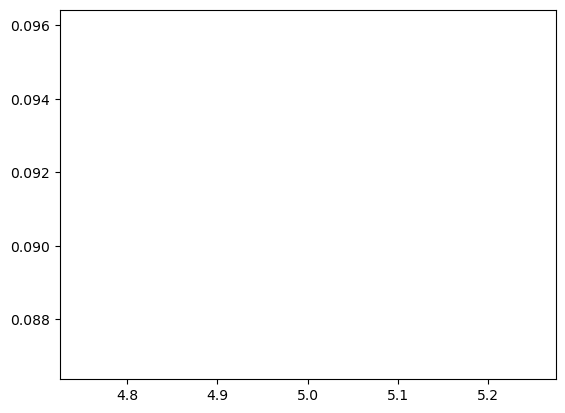

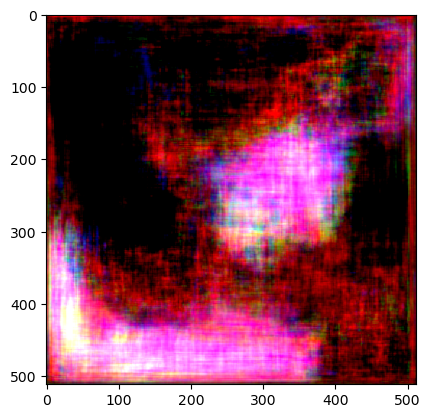

 12%|█▏        | 505/4142 [05:26<37:53,  1.60it/s] 

____________________________
Epoch: 0 | iter: 505


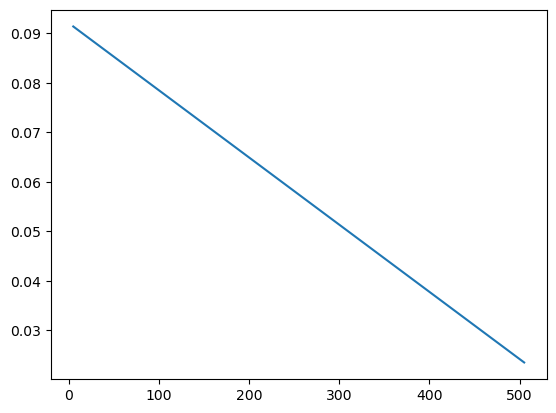

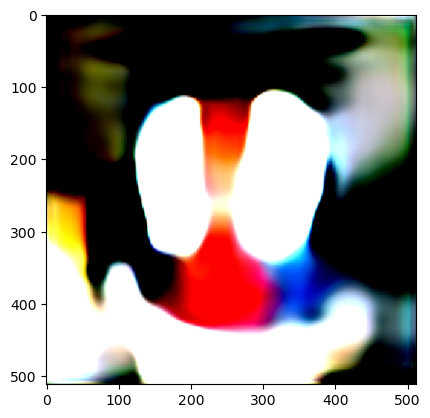

 24%|██▍       | 1005/4142 [10:41<32:47,  1.59it/s] 

____________________________
Epoch: 0 | iter: 1005


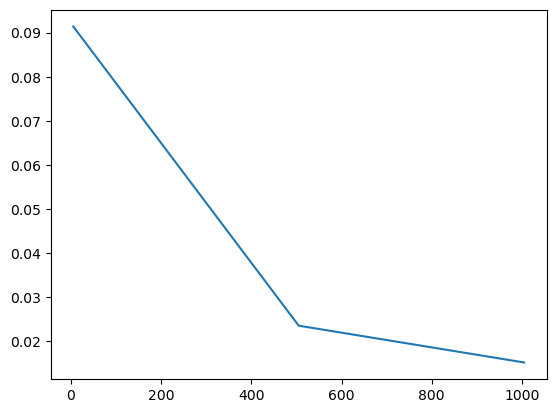

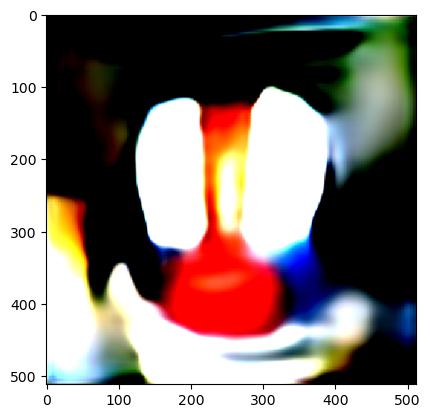

 36%|███▋      | 1505/4142 [15:56<27:29,  1.60it/s]  

____________________________
Epoch: 0 | iter: 1505


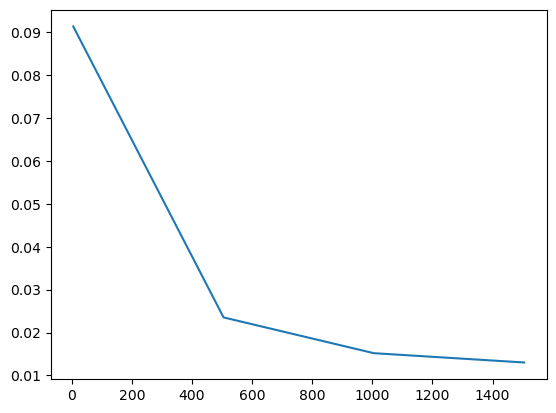

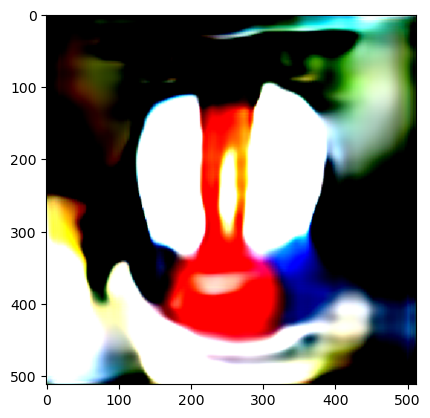

 48%|████▊     | 2005/4142 [21:11<22:17,  1.60it/s]

____________________________
Epoch: 0 | iter: 2005


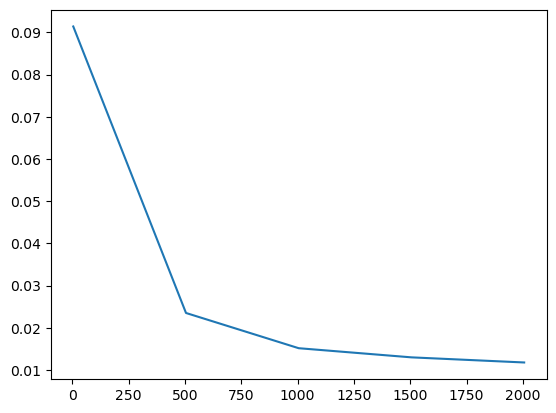

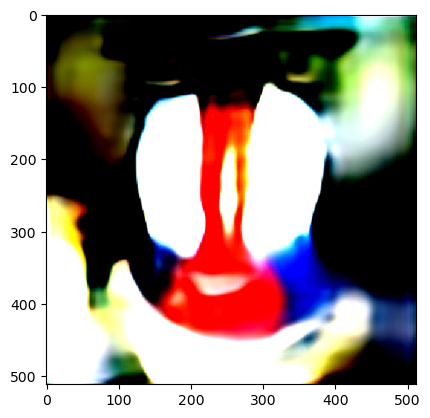

 60%|██████    | 2505/4142 [26:26<17:06,  1.60it/s]

____________________________
Epoch: 0 | iter: 2505


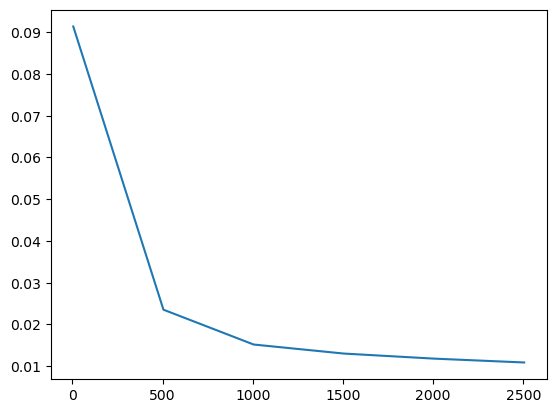

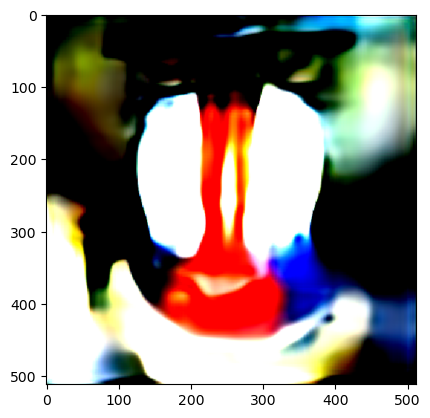

 73%|███████▎  | 3005/4142 [31:47<11:55,  1.59it/s]

____________________________
Epoch: 0 | iter: 3005


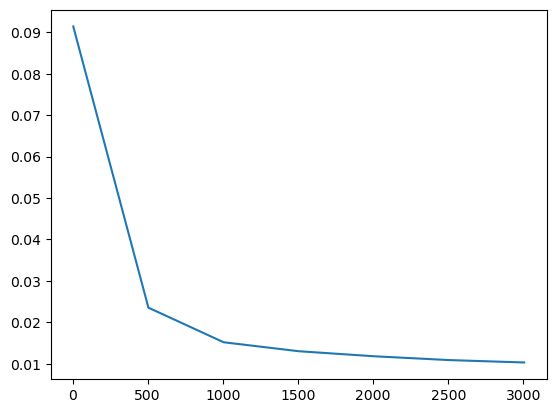

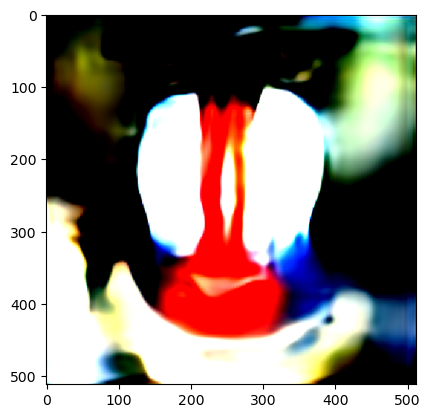

 85%|████████▍ | 3505/4142 [37:05<06:40,  1.59it/s]

____________________________
Epoch: 0 | iter: 3505


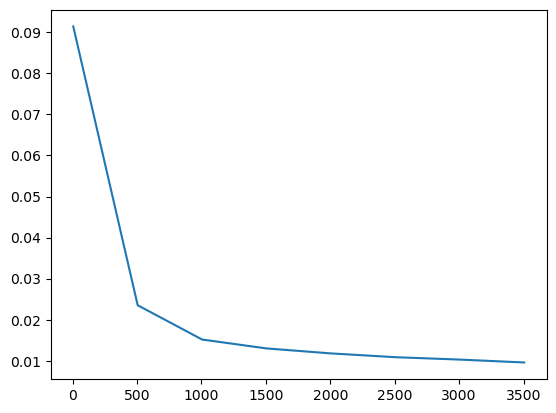

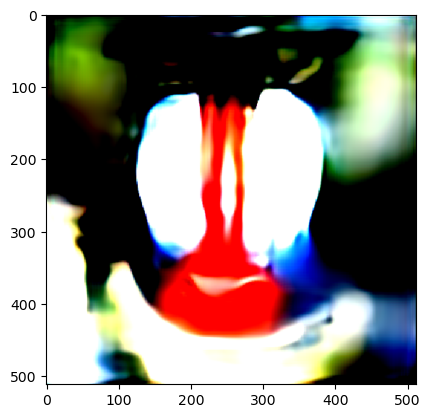

 97%|█████████▋| 4005/4142 [42:24<01:26,  1.59it/s]

____________________________
Epoch: 0 | iter: 4005


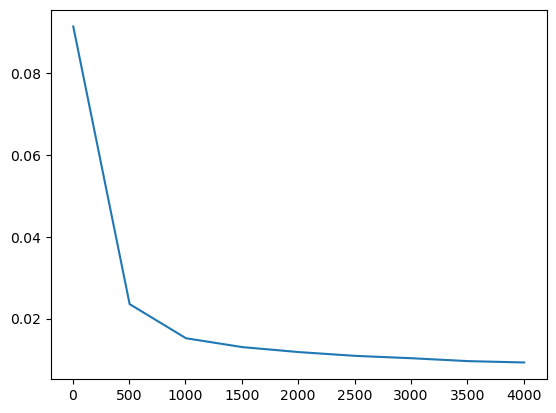

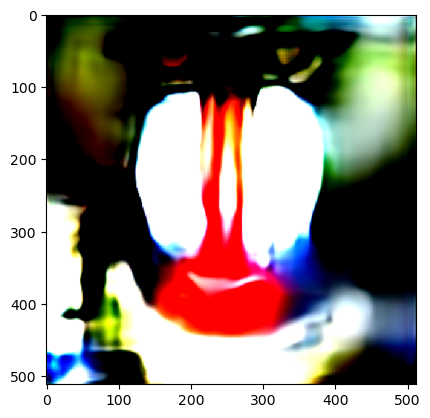

  0%|          | 5/4142 [00:05<1:00:05,  1.15it/s]

____________________________
Epoch: 1 | iter: 5


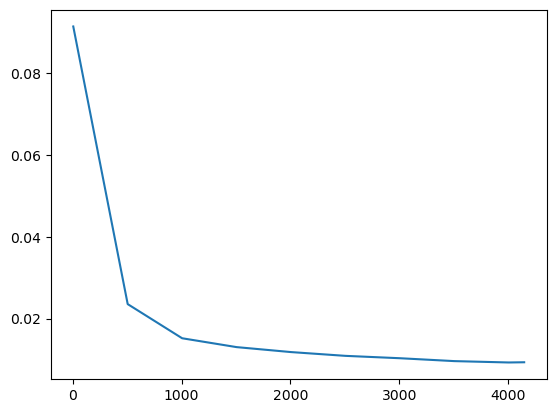

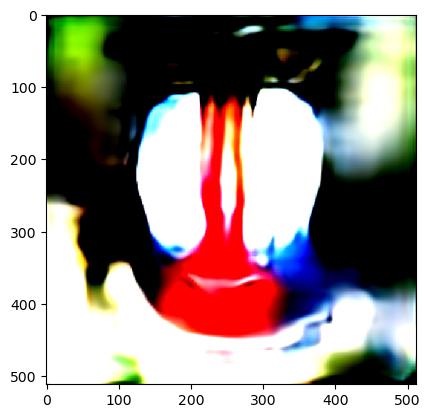

 12%|█▏        | 505/4142 [05:22<38:10,  1.59it/s]

____________________________
Epoch: 1 | iter: 505


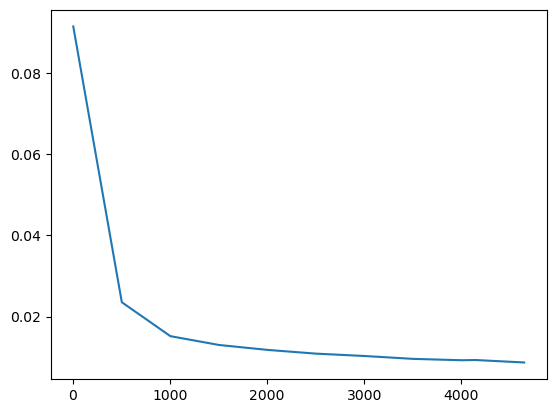

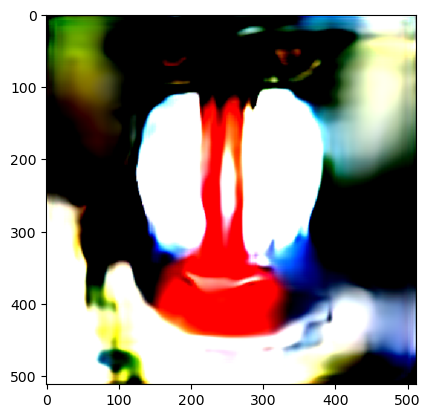

 24%|██▍       | 1005/4142 [10:39<32:57,  1.59it/s] 

____________________________
Epoch: 1 | iter: 1005


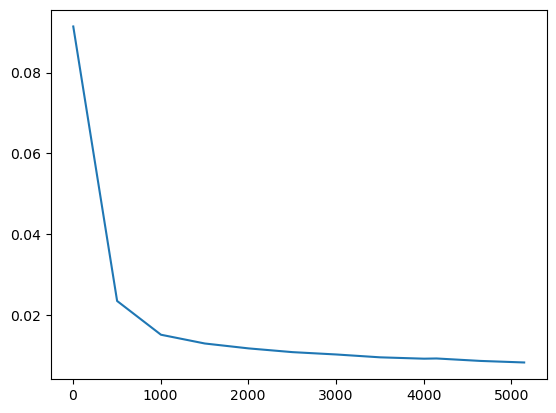

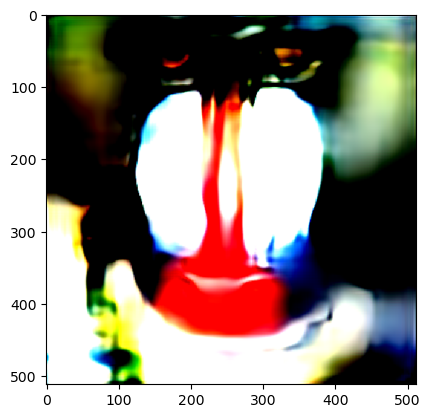

 36%|███▋      | 1505/4142 [15:57<27:40,  1.59it/s]  

____________________________
Epoch: 1 | iter: 1505


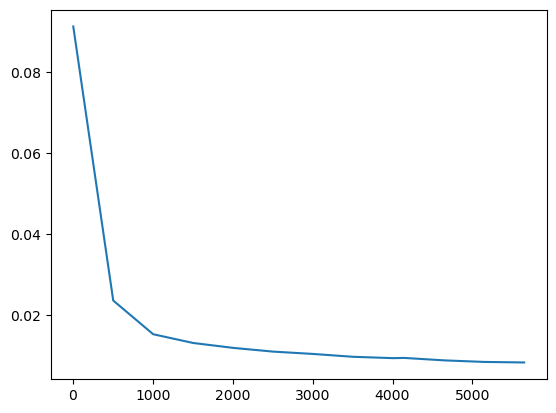

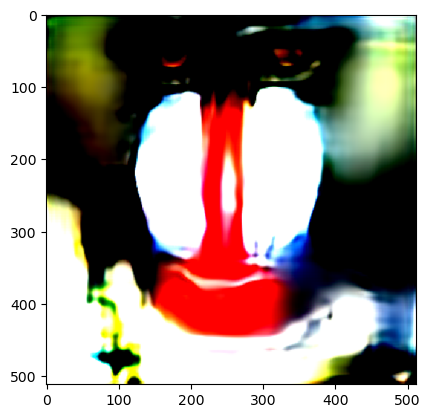

 48%|████▊     | 2005/4142 [21:13<22:27,  1.59it/s]

____________________________
Epoch: 1 | iter: 2005


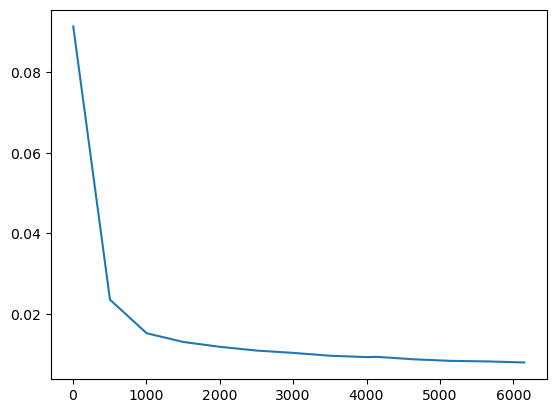

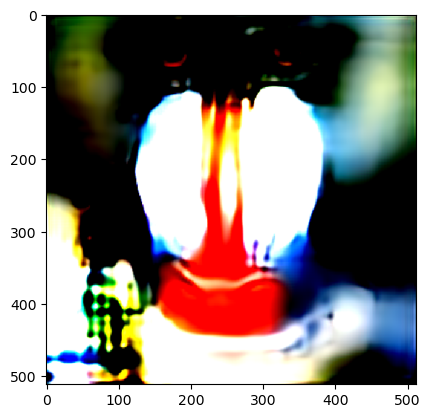

 60%|██████    | 2505/4142 [26:30<17:12,  1.59it/s]

____________________________
Epoch: 1 | iter: 2505


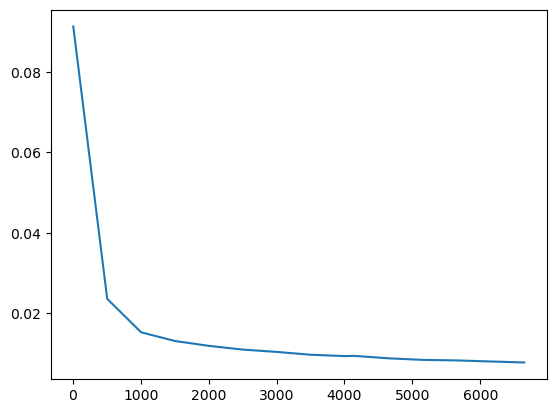

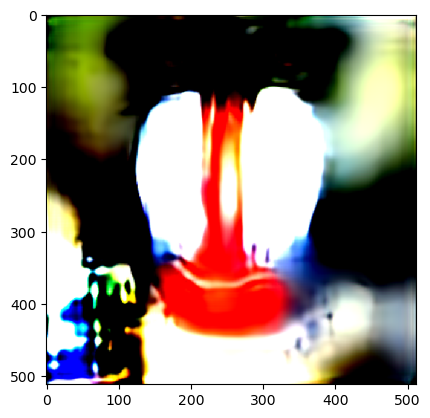

 73%|███████▎  | 3005/4142 [31:47<11:57,  1.59it/s]

____________________________
Epoch: 1 | iter: 3005


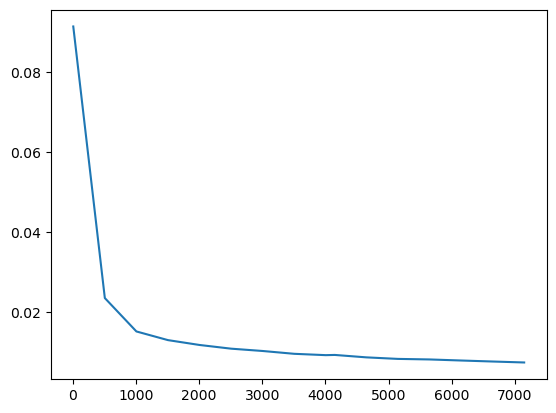

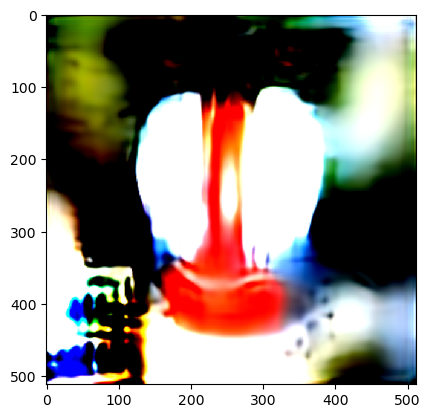

 85%|████████▍ | 3505/4142 [37:05<06:42,  1.58it/s]

____________________________
Epoch: 1 | iter: 3505


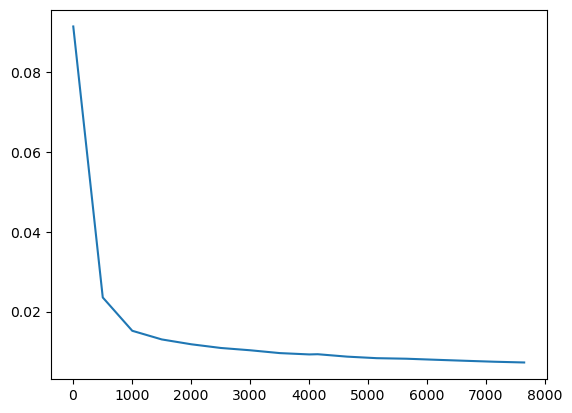

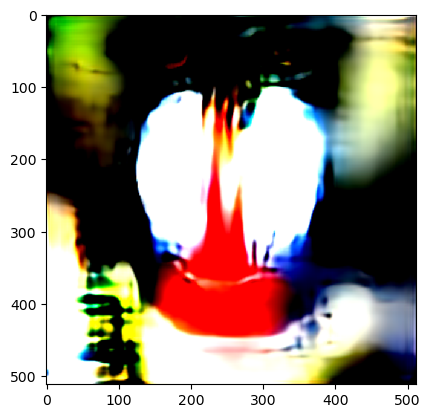

 97%|█████████▋| 4005/4142 [42:22<01:34,  1.45it/s]

____________________________
Epoch: 1 | iter: 4005


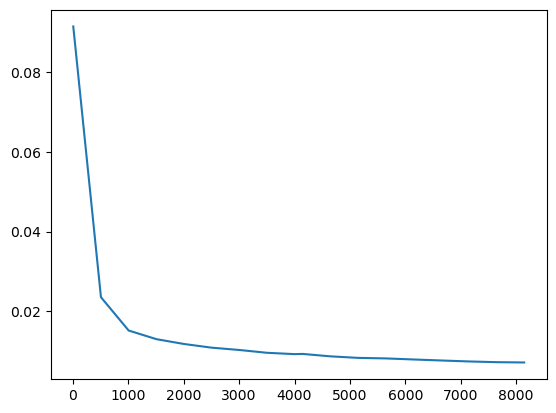

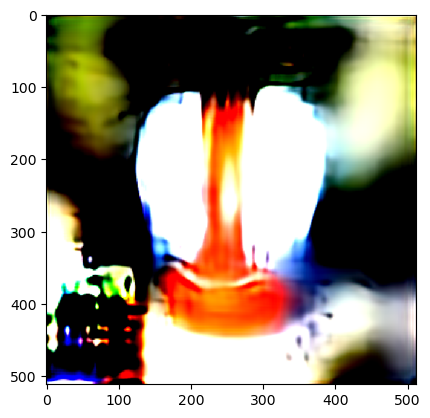

  0%|          | 5/4142 [00:05<1:03:28,  1.09it/s]

____________________________
Epoch: 2 | iter: 5


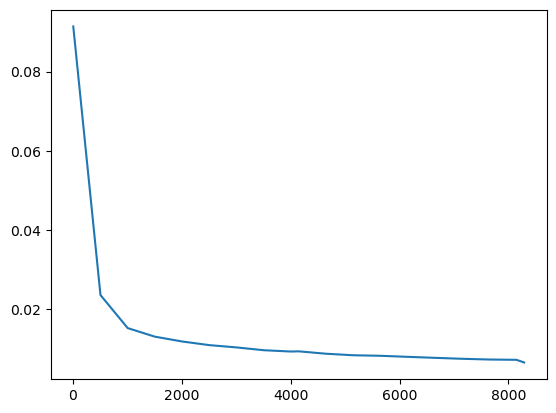

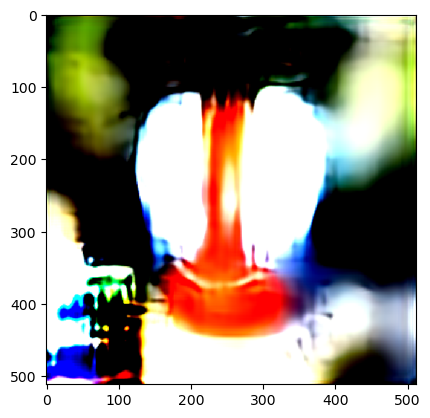

  7%|▋         | 299/4142 [03:12<40:17,  1.59it/s]

In [ ]:
autoencoder = Autoencoder(8).cuda()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)
loss_criterion = torch.nn.MSELoss()
autoencoder.train()

graphics_train = []

autoencoder.train()
for epoch in range(10):
    losses = []
    for iteration, (batch, targets) in tqdm(enumerate(train_loader), total = len(train_loader)):
        batch = batch.cuda()
        
        pred = autoencoder(batch)
        loss = loss_criterion(pred, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
                
        if iteration % 500 == 5:
            print("____________________________")
            print(f"Epoch: {epoch} | iter: {iteration}")
            graphics_train += [[epoch*len(train_loader) +  iteration, sum(losses)/ len(losses)]]
            matplotlib.pyplot.plot([i[0] for i in graphics_train], [i[1] for i in graphics_train])
            matplotlib.pyplot.show()
            losses = []
            torch.save(autoencoder.enc.state_dict(), 'encoder.pth')
            torch.save(autoencoder.dec.state_dict(), 'decoder.pth')
            encoder = Encoder()
            decoder = Decoder()
            encoder.load_state_dict(torch.load("encoder.pth"))
            decoder.load_state_dict(torch.load("decoder.pth"))
        
            image = Image.open("/kaggle/input/datasettest/baboon.png")
            img_tensor = transform(image) 
            dec_img = decoder(encoder(img_tensor.reshape(1,3,512,512)))
            matplotlib.pyplot.imshow( dec_img.squeeze().permute(1,2,0).detach().numpy() )
            matplotlib.pyplot.show()
            

In [11]:
5

5

In [ ]:
88

###### 11

In [ ]:
22

In [ ]:
55

In [ ]:
88

In [ ]:
99

In [ ]:
100

In [ ]:
778

  0%|          | 5/4142 [00:05<58:40,  1.18it/s]  

____________________________
Epoch: 0 | iter: 5


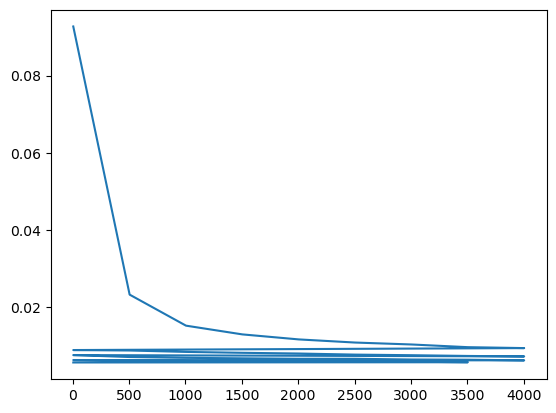

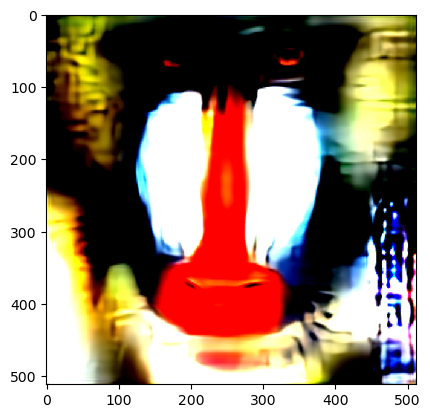

 12%|█▏        | 505/4142 [05:23<38:23,  1.58it/s]

____________________________
Epoch: 0 | iter: 505


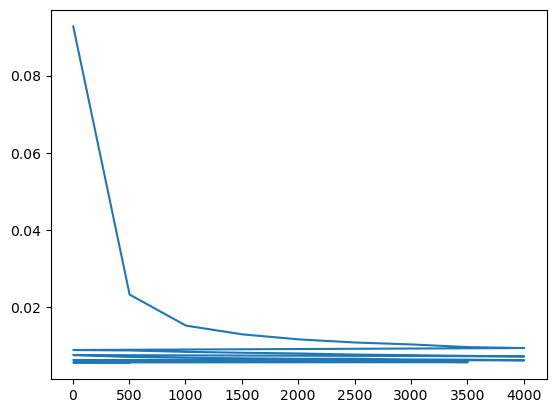

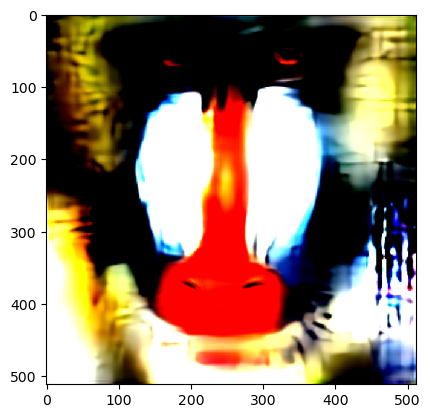

 24%|██▍       | 1005/4142 [10:41<33:11,  1.58it/s] 

____________________________
Epoch: 0 | iter: 1005


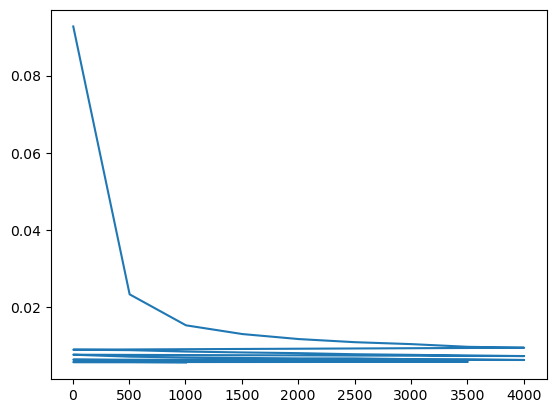

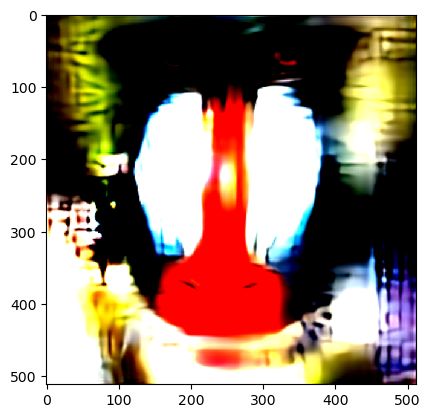

 36%|███▋      | 1505/4142 [16:00<27:50,  1.58it/s]  

____________________________
Epoch: 0 | iter: 1505


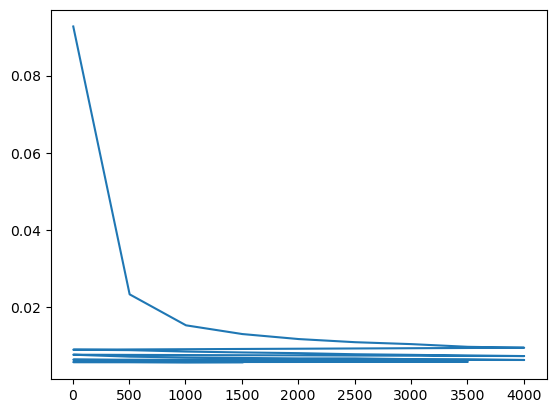

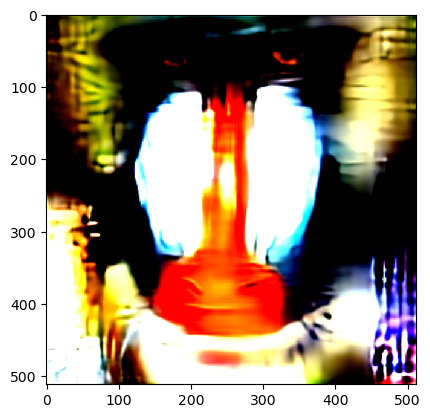

 48%|████▊     | 2005/4142 [21:18<22:34,  1.58it/s]

____________________________
Epoch: 0 | iter: 2005


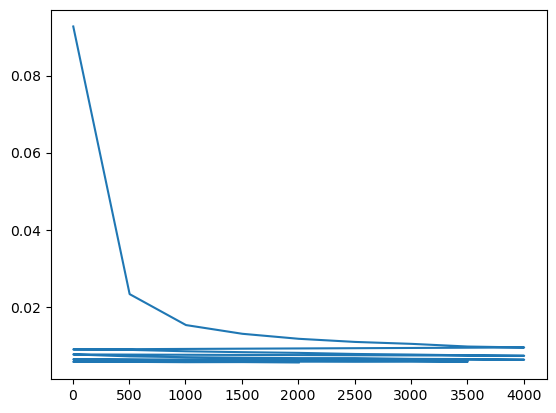

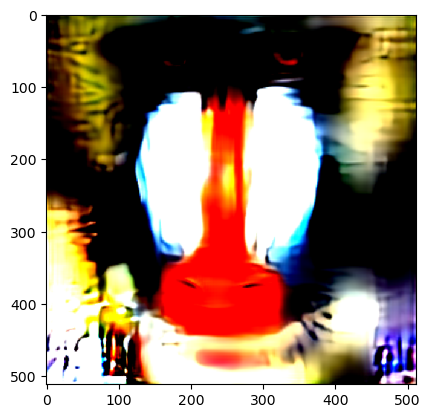

 60%|██████    | 2505/4142 [26:36<17:16,  1.58it/s]

____________________________
Epoch: 0 | iter: 2505


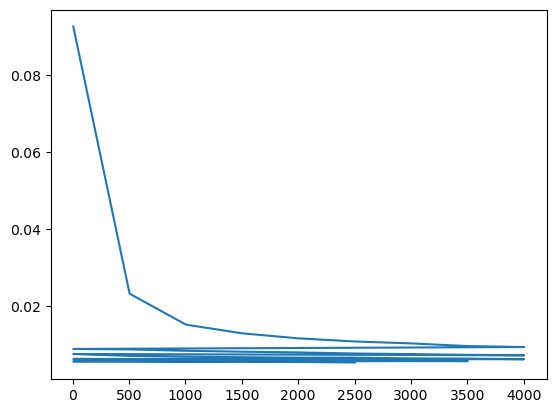

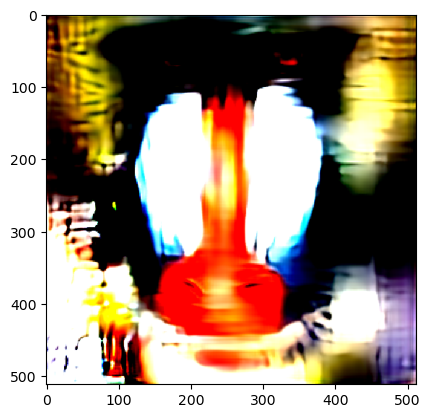

 73%|███████▎  | 3005/4142 [31:54<12:00,  1.58it/s]

____________________________
Epoch: 0 | iter: 3005


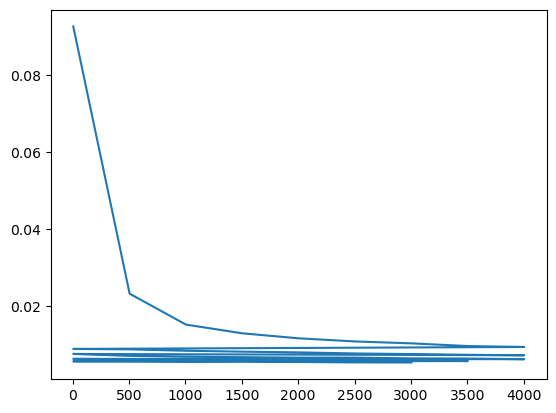

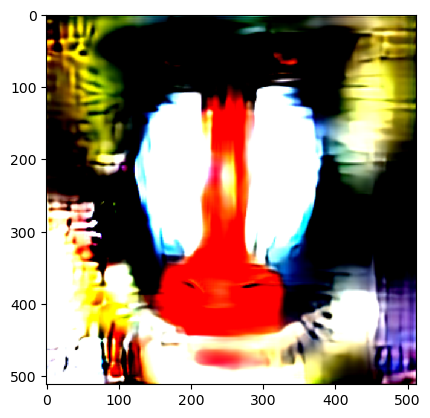

 85%|████████▍ | 3505/4142 [37:12<06:43,  1.58it/s]

____________________________
Epoch: 0 | iter: 3505


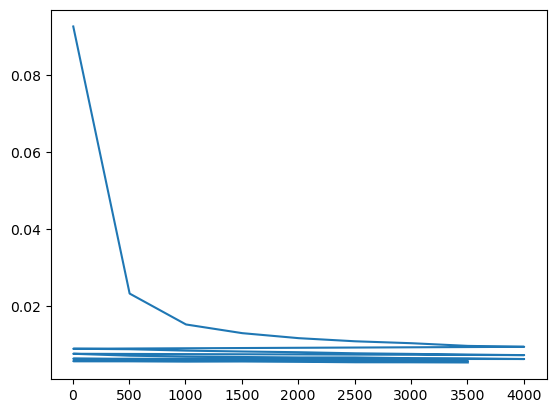

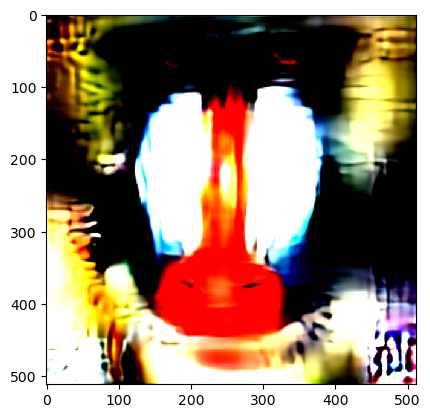

 97%|█████████▋| 4005/4142 [42:30<01:26,  1.58it/s]

____________________________
Epoch: 0 | iter: 4005


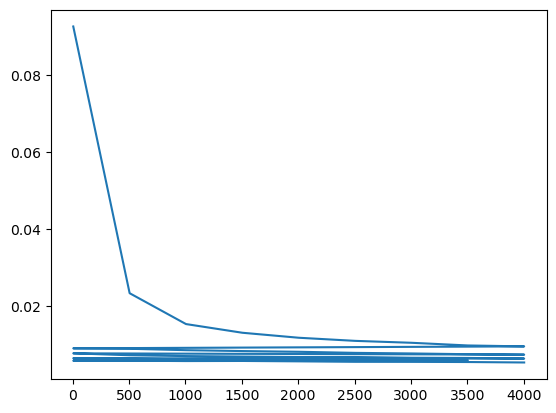

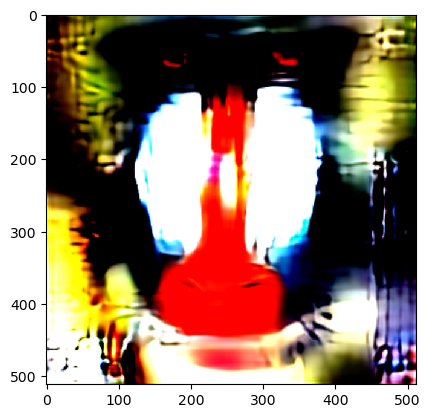

  0%|          | 5/4142 [00:05<59:46,  1.15it/s]  

____________________________
Epoch: 1 | iter: 5


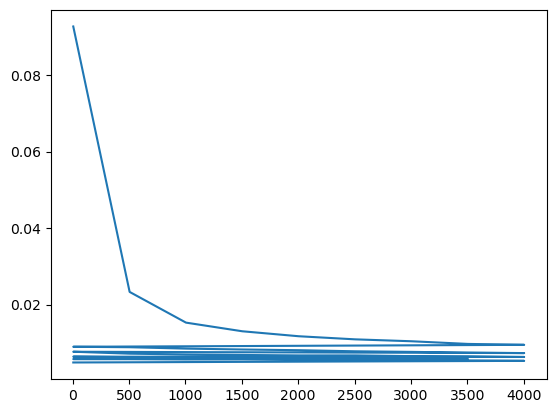

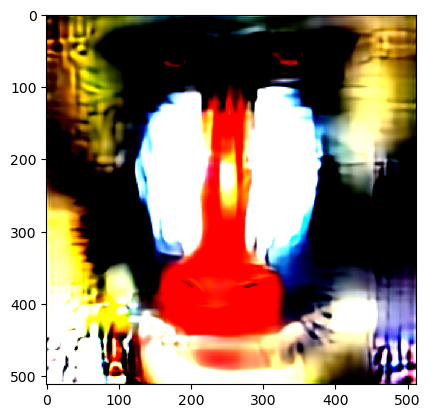

 12%|█▏        | 505/4142 [05:23<38:22,  1.58it/s]

____________________________
Epoch: 1 | iter: 505


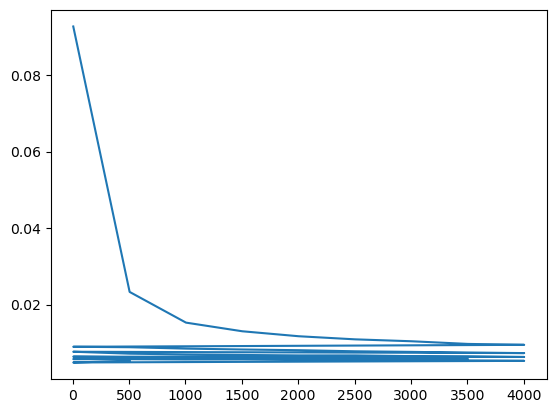

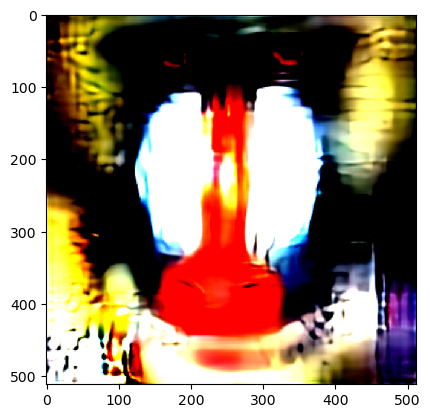

 24%|██▍       | 1005/4142 [10:41<33:12,  1.57it/s] 

____________________________
Epoch: 1 | iter: 1005


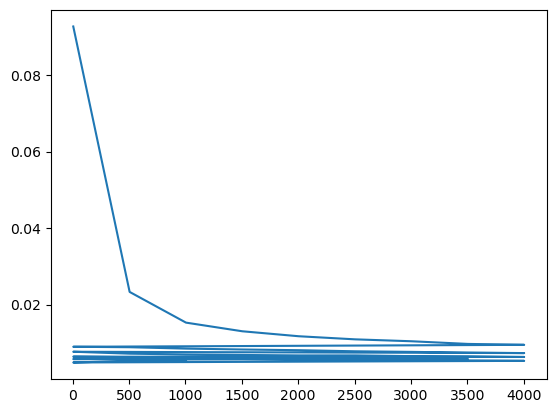

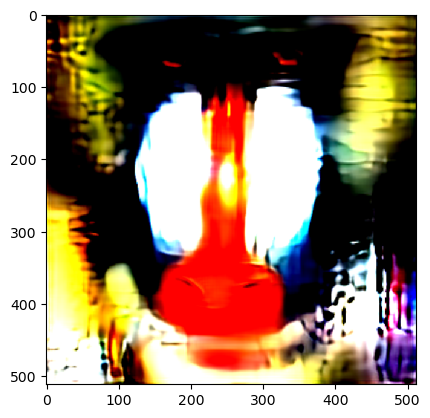

 36%|███▋      | 1505/4142 [16:00<27:52,  1.58it/s]  

____________________________
Epoch: 1 | iter: 1505


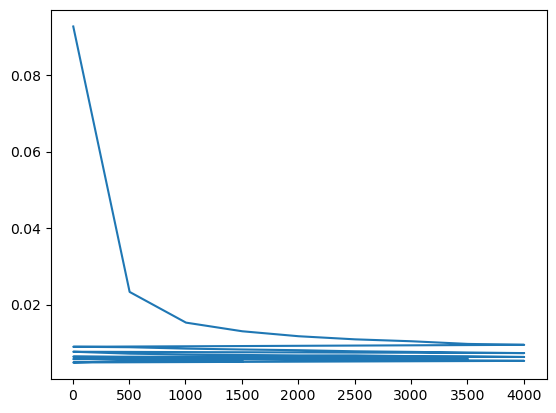

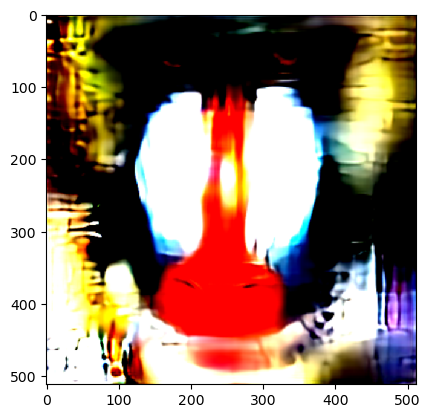

 43%|████▎     | 1770/4142 [18:49<24:45,  1.60it/s]

In [ ]:
autoencoder.train()
for epoch in range(10):
    losses = []
    for iteration, (batch, targets) in tqdm(enumerate(train_loader), total = len(train_loader)):
        batch = batch.cuda()
        
        pred = autoencoder(batch)
        loss = loss_criterion(pred, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
                
        if iteration % 500 == 5:
            print("____________________________")
            print(f"Epoch: {epoch} | iter: {iteration}")
            graphics_train += [[iteration, sum(losses)/ len(losses)]]
            matplotlib.pyplot.plot([i[0] for i in graphics_train], [i[1] for i in graphics_train])
            matplotlib.pyplot.show()
            losses = []
            torch.save(autoencoder.enc.state_dict(), 'encoder.pth')
            torch.save(autoencoder.dec.state_dict(), 'decoder.pth')
            encoder = Encoder()
            decoder = Decoder()
            encoder.load_state_dict(torch.load("encoder.pth"))
            decoder.load_state_dict(torch.load("decoder.pth"))
        
            image = Image.open("/kaggle/input/datasettest/baboon.png")
            img_tensor = transform(image) 
            dec_img = decoder(encoder(img_tensor.reshape(1,3,512,512)))
            matplotlib.pyplot.imshow( dec_img.squeeze().permute(1,2,0).detach().numpy() )
            matplotlib.pyplot.show()